In [23]:
import pandas as pd
import numpy as np
from pathlib import Path

import getpass
pd.options.mode.chained_assignment = None

In [2]:
# Ruta para pcs
user = getpass.getuser() # Capturo el usuario local / Ejemplo "Llan_", este es el nombre de mi usuario que inicie sesion en la pc

if   user== "analistaup29": # PC Analista UP 29 Minedu
     work = Path(r"C:\Users\ANALISTAUP29\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user== "llan_": # PC casa Llan
     work = Path(r"C:\Users\llan_\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user == "USUARIO": # @hugoferquiroz casa
     work =  Path(r'D:\\Trabajo\AITeacherAllocation') 

In [3]:
df = pd.read_csv(work/r'Results\\Base consolidada.csv')
df.set_index(['cod_mod','year'],inplace=True)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_29972\3606240390.py:1: DtypeWarning: Columns (1,122) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(work/r'Results\\Base consolidada.csv')


# Target population

The goal is predict teacher allocation in this population target:

- Educational stage
    - Kindergarten 
    - Primary school

- Teachers:
    - Teachers
    - Education Assistant

- Type of school 
    - Public managed by Central Goverment

In [4]:
# Relevant rows
df = df.loc[df['niv_mod']!='F0'] # Educational stage
df = df.dropna(subset=['region']) # Drop missing in region
df = df.loc[(df['gestion']==1) & (df['ges_dep']=='A1')] # Type of school
df = df.loc[df['estado']==1] # Active in 2022

In [5]:
# Repair educational stage
df.loc[df['d_niv_mod']=='Inicial - Jard¡n','d_niv_mod'] = 'Inicial - Jardin'
df.loc[df['d_niv_mod']=='Inicial - Cuna-jard¡n','d_niv_mod'] = 'Inicial - Cuna-jardin'
# Drop few observations 
df = df.loc[df['d_niv_mod']!='Inicial - Cuna'] # 39 rows deleted
# Drop no relevant information in target variable
df = df.loc[df['secciones_necesarias']!=0] #720 rows deleted

# Data for clusters
Divede the data for educational stage beacuse our objective is identify groups by educational stage

In [6]:
df['d_niv_mod'].value_counts()

Primaria                 87339
Inicial - Jardin         71487
Inicial - Cuna-jardin     1261
Name: d_niv_mod, dtype: int64

In [7]:
def drop_no_relevant(df):
    '''
    Drop no relevant columns
    df: 
        - type: data frame
    '''
    df = df.drop(columns=['Unnamed: 0.1','usuario_minedu','bolsa_nexus','bolsa_sira',
'dir_req', 'sub_dir_req','jer_req','fisica_req','aip_req','dir_exd','sub_dir_exd',
'jer_exd','niv_mod','gestion','d_gestion','ges_dep','d_ges_dep','estado',
'd_estado','d_region','tipo_entidad','jec','Unnamed: 0','otro_doc_exd','d_dpto','codlocal','d_dist','d_niv_mod',]) 
    df['doc_exd']= df['doc_aula_exd_n']+df['doc_aula_exd_c']
    df = df.drop(columns=['doc_aula_exd_n', 'doc_aula_exd_c'])
    return df

## Primary level

In [8]:
# Primary
df_primaria = df.loc[df['d_niv_mod']=='Primaria']
df_primaria = drop_no_relevant(df_primaria)
# Enrollment in primary is 1 - 6
enrolment_no_primary = [ x for x in df_primaria.columns.to_list() if (x.find('cant0')!=-1) | (x.find('inclu0')!=-1) ]
df_primaria = df_primaria.drop(columns=enrolment_no_primary)

In [9]:
num_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'int64') | (df_primaria[x].dtype =='float64') ]
str_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'object') ]

In [10]:
df_primaria[['nlat_ie','nlong_ie']].isnull().sum()

nlat_ie     0
nlong_ie    0
dtype: int64

In [11]:
df_primaria[str_primaria].isnull().sum()

d_prov            0
d_dreugel         0
region            0
ruralidad         0
vraem             0
frontera          0
bilingue          0
caracteristica    0
dtype: int64

<AxesSubplot:ylabel='cod_mod-year'>

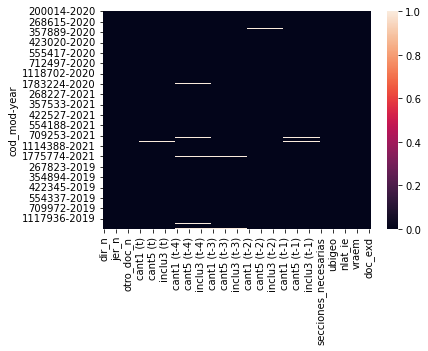

In [12]:
# Inspecting missing
import seaborn as sns
sns.heatmap(df_primaria.isnull())

In [13]:
# Imputing missing
df_primaria.fillna(0,inplace=True)

In [14]:
# Labor force
df_primaria['Directores'] = df_primaria['dir_n'] + df_primaria['dir_c']
df_primaria['Subdirectores'] = df_primaria['sub_dir_n'] + df_primaria['sub_dir_c']
df_primaria['Jerarquicos'] = df_primaria['jer_n'] + df_primaria['jer_c']
df_primaria['Docentes de aula'] = df_primaria['doc_aula_n'] + df_primaria['doc_aula_c']
df_primaria['Otros docentes'] = df_primaria['otro_doc_n'] + df_primaria['otro_doc_c']
df_primaria['Auxiliares'] = df_primaria['aux_n'] + df_primaria['aux_c']
personal = ['Directores','Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']

In [ ]:
# Enrollment
df_primaria['enrrolment'] = 





### Finding optimal clusters

In [15]:
# Determino la cantidad de clusters
from sklearn.cluster import KMeans

In [16]:
df_primaria_knn = df_primaria[num_primaria]

In [17]:
## Vamos a hacer el grafico del codo. Para esto vamos a probar hacer distintos clusters y vamos a guardar el error (que lo definimos como wcss)
# WCSS --> Wihin Cluster Sum of Squares
wcss = []
for i in range(1,12):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=36963)
  kmeans.fit(df_primaria_knn)
  wcss.append(kmeans.inertia_)

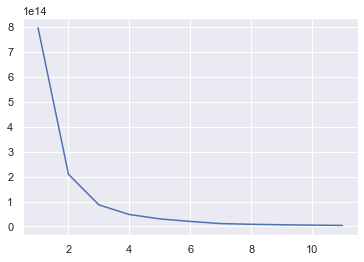

In [18]:
import matplotlib.pyplot as plt
sns.set()
plt.plot(range(1,12),wcss)

In [19]:
## El numero optimo de clusters es igual a 5, asi que haremos 5 clusters
kmeans = KMeans(n_clusters=8,init='k-means++',random_state=42)
kmeans.fit(df_primaria_knn)
clusters = kmeans.predict(df_primaria_knn)

In [28]:
df_primaria_knn['Segmento'] = clusters

In [26]:
# Caraterizar los clusters

df_primaria_knn['Directores'] = df_primaria_knn['dir_n'] + df_primaria_knn['dir_c']
df_primaria_knn['Subdirectores'] = df_primaria_knn['sub_dir_n'] + df_primaria_knn['sub_dir_c']
df_primaria_knn['Jerarquicos'] = df_primaria_knn['jer_n'] + df_primaria_knn['jer_c']
df_primaria_knn['Docentes de aula'] = df_primaria_knn['doc_aula_n'] + df_primaria_knn['doc_aula_c']
df_primaria_knn['Otros docentes'] = df_primaria_knn['otro_doc_n'] + df_primaria_knn['otro_doc_c']
df_primaria_knn['Auxiliares'] = df_primaria_knn['aux_n'] + df_primaria_knn['aux_c']


personal = ['Directores','Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']





In [27]:
df_primaria_knn[personal].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Directores,87339.0,0.236114,0.424965,0.0,0.0,0.0,0.0,2.0
Subdirectores,87339.0,0.062538,0.287886,0.0,0.0,0.0,0.0,6.0
Jerarquicos,87339.0,0.000137,0.011721,0.0,0.0,0.0,0.0,1.0
Docentes de aula,87339.0,4.302912,6.313760,0.0,1.0,2.0,4.0,80.0
Otros docentes,87339.0,0.333608,0.934679,0.0,0.0,0.0,0.0,12.0
Auxiliares,87339.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
'cant1 (t)',
 'cant2 (t)',
 'cant3 (t)',
 'cant4 (t)',
 'cant5 (t)',
 'cant6 (t)'


 'inclu1 (t)',
 'inclu2 (t)',
 'inclu3 (t)',
 'inclu4 (t)',
 'inclu5 (t)',
 'inclu6 (t)',

In [21]:
num_primaria

['dir_n',
 'dir_c',
 'sub_dir_n',
 'sub_dir_c',
 'jer_n',
 'jer_c',
 'doc_aula_n',
 'doc_aula_c',
 'otro_doc_n',
 'otro_doc_c',
 'aux_n',
 'aux_c',
 'cant1 (t)',
 'cant2 (t)',
 'cant3 (t)',
 'cant4 (t)',
 'cant5 (t)',
 'cant6 (t)',
 'inclu1 (t)',
 'inclu2 (t)',
 'inclu3 (t)',
 'inclu4 (t)',
 'inclu5 (t)',
 'inclu6 (t)',
 'cant1 (t-4)',
 'cant2 (t-4)',
 'cant3 (t-4)',
 'cant4 (t-4)',
 'cant5 (t-4)',
 'cant6 (t-4)',
 'inclu1 (t-4)',
 'inclu2 (t-4)',
 'inclu3 (t-4)',
 'inclu4 (t-4)',
 'inclu5 (t-4)',
 'inclu6 (t-4)',
 'cant1 (t-3)',
 'cant2 (t-3)',
 'cant3 (t-3)',
 'cant4 (t-3)',
 'cant5 (t-3)',
 'cant6 (t-3)',
 'inclu1 (t-3)',
 'inclu2 (t-3)',
 'inclu3 (t-3)',
 'inclu4 (t-3)',
 'inclu5 (t-3)',
 'inclu6 (t-3)',
 'cant1 (t-2)',
 'cant2 (t-2)',
 'cant3 (t-2)',
 'cant4 (t-2)',
 'cant5 (t-2)',
 'cant6 (t-2)',
 'inclu1 (t-2)',
 'inclu2 (t-2)',
 'inclu3 (t-2)',
 'inclu4 (t-2)',
 'inclu5 (t-2)',
 'inclu6 (t-2)',
 'cant1 (t-1)',
 'cant2 (t-1)',
 'cant3 (t-1)',
 'cant4 (t-1)',
 'cant5 (t-1)',
 'ca

In [37]:
# Enrollment in primary is 1 - 6
enrolment_no_primary = [ x for x in df_primaria.columns.to_list() if (x.find('cant0')!=-1) | (x.find('inclu0')!=-1) ]

In [7]:
# Other outcomes not relevant to predict in this version
other_outcomes=['doc_aula_req','aux_req','doc_aula_exd_n', 'doc_aula_exd_c', 'aux_exd']
#df = df.drop(columns=other_outcomes)

In [ ]:
# Reducir la dimensionalidad?